In [1]:
import turicreate as tc

In [3]:
loans = tc.SFrame('lending-club-data.SFrame')

In [4]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

In [5]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

In [6]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [8]:
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print ('Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows))

Dropping 29 observations; keeping 122578 


In [9]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print ("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print ("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print ("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5022471668494506
Percentage of risky loans                : 0.4977528331505494
Total number of loans in our new dataset : 46503


In [10]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

In [11]:
model_5 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training Accuracy | Training Log Loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.090810     | 0.657541          | 0.657139          |

| 2         | 0.172728     | 0.656976          | 0.636157          |

| 3         | 0.255103     | 0.664983          | 0.623206          |

| 4         | 0.339847     | 0.668476          | 0.613783          |

| 5         | 0.412597     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

In [12]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 25 columns]

In [13]:
model_5.predict(sample_validation_data)

dtype: int
Rows: 4
[1, 1, -1, 1]

In [14]:
len(sample_validation_data[sample_validation_data['safe_loans'] == model_5.predict(sample_validation_data)])/float(len(sample_validation_data))

0.75

In [15]:
model_5.predict(sample_validation_data, output_type='probability')

dtype: float
Rows: 4
[0.7045905590057373, 0.5963408946990967, 0.44925159215927124, 0.6119099855422974]

In [16]:
model_5.evaluate(validation_data)

{'accuracy': 0.66813873330461,
 'auc': 0.7247215702188436,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      -1      |        1        |  1618 |
 |      -1      |        -1       |  3054 |
 |      1       |        -1       |  1463 |
 |      1       |        1        |  3149 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6715001599317625,
 'log_loss': 0.617613176969398,
 'precision': 0.6605831760016782,
 'recall': 0.6827840416305291,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 4612 | 4672 |
 |   1e-05   | 1.0 | 1.0 | 4612 | 4672 |
 |   2e-05   | 1.0 | 1

In [17]:
predictions = model_5.predict(validation_data)

In [18]:
confusion_matrix = model_5.evaluate(validation_data)['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
-1,1,1618
-1,-1,3054
1,-1,1463
1,1,3149


In [19]:
# false_positives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == -1).sum()
false_positives = confusion_matrix[(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == 1)]['count'][0]
print( false_positives)

1618


In [20]:
# false_negatives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == +1).sum()
false_negatives = confusion_matrix[(confusion_matrix['target_label'] == 1) & (confusion_matrix['predicted_label'] == -1)]['count'][0]
print (false_negatives)

1463


In [21]:
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print (cost_of_mistakes)

46990000


In [22]:
validation_data['predictions'] = model_5.predict(validation_data, output_type='probability')

In [23]:
validation_data[['grade','predictions']].sort('predictions', ascending = False)[0:5]

grade,predictions
A,0.848508358001709
A,0.848508358001709
A,0.8412954211235046
A,0.8412954211235046
A,0.8412954211235046


In [24]:
validation_data[['grade','predictions']].sort('predictions', ascending = True)[0:5]

grade,predictions
D,0.13427510857582092
C,0.13427510857582092
B,0.13427510857582092
C,0.13427510857582092
C,0.13427510857582092


In [26]:
model_10 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 10, verbose=True)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training Accuracy | Training Log Loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.075141     | 0.657541          | 0.657139          |

| 2         | 0.144153     | 0.656976          | 0.636157          |

| 3         | 0.216393     | 0.664983          | 0.623206          |

| 4         | 0.295356     | 0.668476          | 0.613783          |

| 5         | 0.377757     | 0.673339          | 0.606229          |

| 10        | 0.683848     | 0.688251          | 0.585475          |

+-----------+--------------+-------------------+-------------------+

In [28]:
model_50 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 50, verbose=False)
model_100 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 100, verbose=False)
model_200 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 200, verbose=False)
model_500 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 500, verbose=False)

In [29]:
print (model_10.evaluate(validation_data)['accuracy'])
print (model_50.evaluate(validation_data)['accuracy'])
print (model_100.evaluate(validation_data)['accuracy'])
print (model_200.evaluate(validation_data)['accuracy'])
print (model_500.evaluate(validation_data)['accuracy'])

0.6727703576044808
0.6907582938388626
0.6917277035760449
0.684510986643688
0.6718009478672986


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [31]:

train_err_10 = 1 - model_10.evaluate(train_data)['accuracy']
train_err_50 = 1 - model_50.evaluate(train_data)['accuracy']
train_err_100 = 1 - model_100.evaluate(train_data)['accuracy']
train_err_200 = 1 - model_200.evaluate(train_data)['accuracy']
train_err_500 = 1 - model_500.evaluate(train_data)['accuracy']

In [32]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

In [33]:

validation_err_10 = 1 - model_10.evaluate(validation_data)['accuracy']
validation_err_50 = 1 - model_50.evaluate(validation_data)['accuracy']
validation_err_100 = 1 - model_100.evaluate(validation_data)['accuracy']
validation_err_200 = 1 - model_200.evaluate(validation_data)['accuracy']
validation_err_500 = 1 - model_500.evaluate(validation_data)['accuracy']

In [34]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

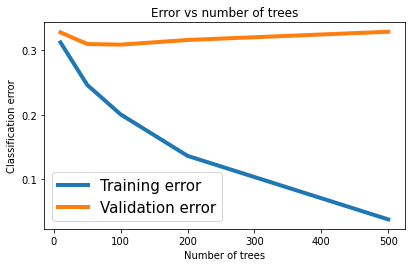

In [35]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

In [38]:
loans = tc.SFrame('lending-club-data.SFrame')
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

In [39]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

print ("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print ("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print ("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5022361744216048
Percentage of risky loans                : 0.4977638255783951
Total number of loans in our new dataset : 46508


In [40]:
loans_data = risky_loans.append(safe_loans)
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data = loans_data.remove_column(feature)
    loans_data = loans_data.add_columns(loans_data_unpacked)

In [42]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable
features

['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

In [43]:
train_data, test_data = loans_data.random_split(0.8, seed=1)

In [44]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_positive <= weighted_mistakes_all_negative:        
        return (weighted_mistakes_all_positive, +1)
    else:        
        return (weighted_mistakes_all_negative, -1)

In [46]:
example_labels = tc.SArray([-1, -1, 1, 1, 1])
example_data_weights = tc.SArray([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


In [47]:

example_labels = tc.SArray([1, 1, 1, 1, 1])
example_data_weights = tc.SArray([1., 2., .5, 1., 1.])

print (intermediate_node_weighted_mistakes(example_labels, example_data_weights))

(0, 1)


In [48]:

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes + right_weighted_mistakes)/(sum(left_data_weights) + sum(right_data_weights))
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [51]:
example_data_weights = tc.SArray(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term. 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


In [52]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf

In [53]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print( "--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print( "Stopping condition 1 reached." )               
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print( "Stopping condition 2 reached." )               
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print( "Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [54]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [56]:
example_data_weights = tc.SArray([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print ('Test passed!')
else:
    print ('Test failed... try again!')
    print ('Number of nodes found:', count_nodes(small_data_decision_tree))
    print( 'Number of nodes that should be there: 7')

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade.D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

In [57]:
small_data_decision_tree

{'is_leaf': False,
 'prediction': None,
 'splitting_feature': 'term. 36 months',
 'left': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade.A',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}},
 'right': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade.D',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}}

In [59]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [60]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [61]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

In [62]:
# Assign weights
example_data_weights = tc.SArray([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership.RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade.F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade.D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [63]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [64]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

In [69]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = tc.SArray([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = 1./2. * log((1 - weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = (alpha * adjustment)/float(sum(alpha))

    return weights, tree_stumps

In [70]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


In [75]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print( "(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('.')
    print ('                       %s' % 'root')
    print( '         |---------------|----------------|')
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('  [{0} == 0]               [{0} == 1]    '.format(split_name))
    print ('         |                                |')
    print( '         |                                |')
    print ('         |                                |')
    print ('    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

In [76]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]               [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                         (leaf, label: 1)


In [77]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]               [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                         (leaf, label: 1)


In [79]:
stump_weights

[0.15802933659263743, 0.17682363293605327]

In [80]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

In [81]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = tc.SArray([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores += (stump_weights[i] * predictions)
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [82]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = tc.evaluation.accuracy(test_data[target], predictions)
print ('Accuracy of 10-component ensemble = %s' % accuracy)

Accuracy of 10-component ensemble = 0.6203145196036192


In [83]:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

In [84]:
# this may take a while... 
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature emp_length.n/a. (35781, 1443)
--------------------------------------------------------------------
Subtree, depth = 2 (35781 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1443 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
-------------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


In [85]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - tc.evaluation.accuracy(train_data[target], predictions)
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3844831291639802
Iteration 11, training error = 0.3827369439071566
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.3815280464216635
Iteration 14, training error = 0.38056092843326883
Iteration 15, training error = 0.3805071996561358
Iteration 16, training error = 0.378223726627982
Iteration 17, training error = 0.3782774554051149
Iteration 18, training error = 0.3784117773479475
Iteration 19, training error = 0.3780625402965828
Iteration 20, training error = 0.3787610143993123
Iterati

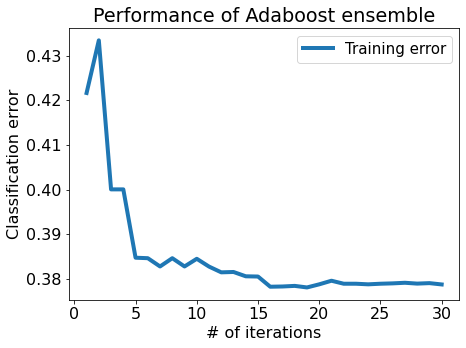

In [86]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [88]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - tc.evaluation.accuracy(test_data[target], predictions)
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.4284791038345541
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.37990090478242133
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.37925463162429984
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.37925463162429984
Iteration 10, test error = 0.37968548039638084
Iteration 11, test error = 0.37925463162429984
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.37925463162429984
Iteration 14, test error = 0.37785437311503667
Iteration 15, test error = 0.37850064627315816
Iteration 16, test error = 0.37785437311503667
Iteration 17, test error = 0.37796208530805686
Iteration 18, test error = 0.37785437311503667
Iteration 19, test error = 0.37817750969409736
Iteration 20, test error = 0.3768849633778544
Iteration 21, test error = 0.37753123653597587
Iteration 22, test error = 

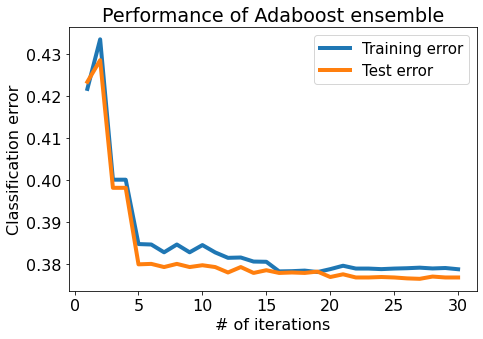

In [89]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()